Day 13 - Merton's Jump-Diffusion Model. Used basically for more realistic cases, with jumps/gaps in the prices (fvg = fair value gap, term used basically with the price action / SMC / ICT trading concepts !)

Running Merton Jump-Diffusion simulation...
Path simulation finished in 0.01s


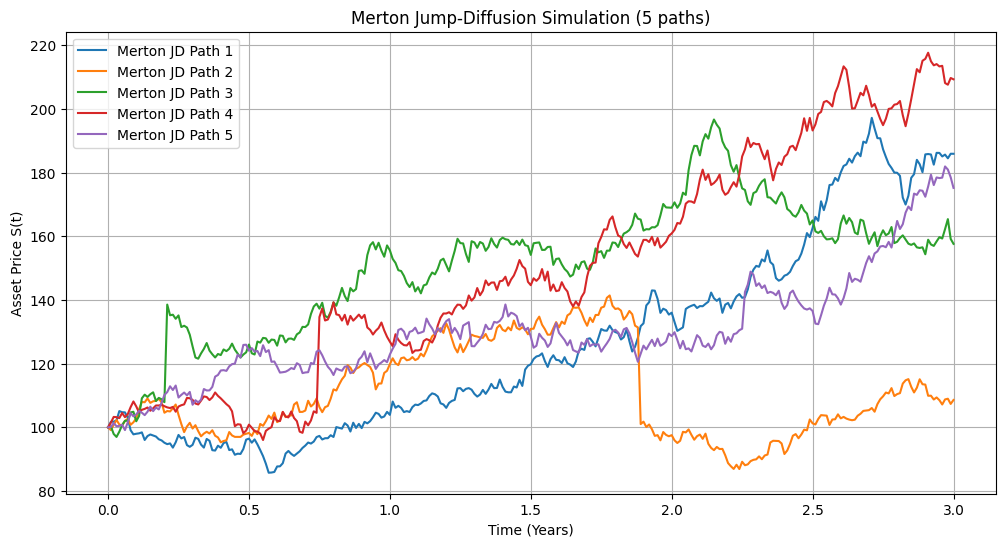


Running GBM simulation for comparison...


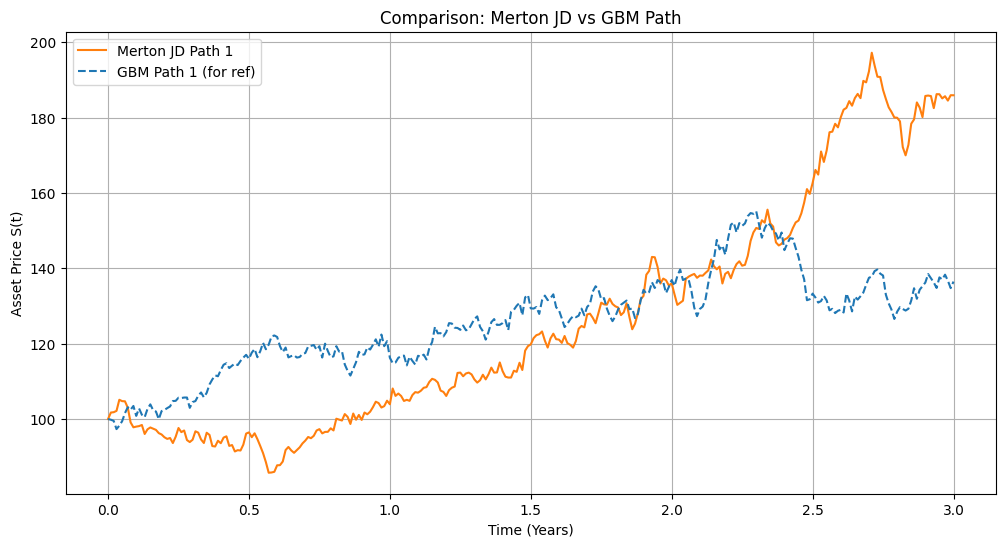


Running simulations for distribution analysis...


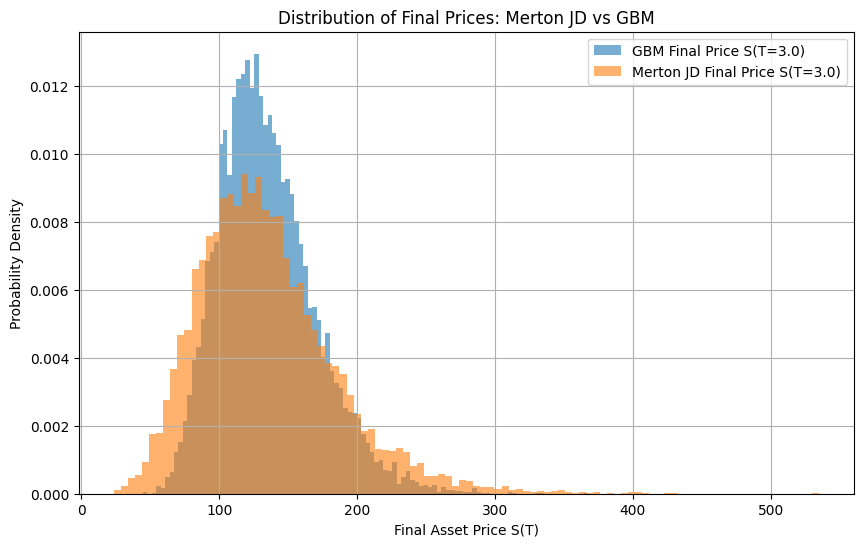

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import time 

notebook_dir = os.path.dirname(os.path.abspath("__file__")) 
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from sde_simulator.simulators import simulate_merton_jd_vectorized
from sde_simulator.simulators import simulate_gbm_em_vectorized #for comparison plot

S0_JD = 100.0     #initial price
MU_JD = 0.10      #overall expected return (annual)
SIGMA_JD = 0.15   #volatility of continuous part (annual)
LAMBDA_JUMP = 0.5 #average jumps per year (1 every 2 years)
K_JUMP = -0.05    #average relative jump size E[Y-1] (e.g., -5% average jump)
NU_JUMP = 0.20    #volatility of jump size (log-normal stdev)

#simulation settings
T_JD = 3.0        #time horizon (3 years)
DT_JD = 0.01      #time step
NUM_PATHS_JD = 5  #number of paths for path visualization
NUM_PATHS_DIST = 10000 #number of paths for distribution plot

print("Running Merton Jump-Diffusion simulation...")
start_time = time.time()
t_jd, S_jd_paths = simulate_merton_jd_vectorized(
    S0_JD, MU_JD, SIGMA_JD, LAMBDA_JUMP, K_JUMP, NU_JUMP,
    T_JD, DT_JD, NUM_PATHS_JD
)
end_time = time.time()
print(f"Path simulation finished in {end_time - start_time:.2f}s")

plt.figure(figsize=(12, 6))
#plot jump paths
for i in range(NUM_PATHS_JD):
     plt.plot(t_jd, S_jd_paths[:, i], lw=1.5, label=f'Merton JD Path {i+1}' if i<5 else None)

plt.title(f'Merton Jump-Diffusion Simulation ({NUM_PATHS_JD} paths)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price S(t)')
if NUM_PATHS_JD <= 10: #only show legend if few paths
    plt.legend()
plt.grid(True)
plt.show()

print("\nRunning GBM simulation for comparison...")
drift_adj = MU_JD - LAMBDA_JUMP * K_JUMP #use adjusted drift for visual fairness? or MU_JD? Let's use MU_JD
t_gbm, S_gbm_paths = simulate_gbm_em_vectorized(
    S0_JD, MU_JD, SIGMA_JD, T_JD, DT_JD, NUM_PATHS_JD 
)

plt.figure(figsize=(12, 6))
#plot one jump path
plt.plot(t_jd, S_jd_paths[:, 0], lw=1.5, label='Merton JD Path 1', color='tab:orange')
#plot one GBM path (using same initial seed might be better for direct compare)
plt.plot(t_gbm, S_gbm_paths[:, 0], lw=1.5, label='GBM Path 1 (for ref)', color='tab:blue', linestyle='--')

plt.title(f'Comparison: Merton JD vs GBM Path')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price S(t)')
plt.legend()
plt.grid(True)
plt.show()


print("\nRunning simulations for distribution analysis...")
#run merton with many paths
_, S_jd_dist = simulate_merton_jd_vectorized(
    S0_JD, MU_JD, SIGMA_JD, LAMBDA_JUMP, K_JUMP, NU_JUMP,
    T_JD, DT_JD, NUM_PATHS_DIST
)
S_T_jd = S_jd_dist[-1, :]

#run gbm with many paths
_, S_gbm_dist = simulate_gbm_em_vectorized(
    S0_JD, MU_JD, SIGMA_JD, T_JD, DT_JD, NUM_PATHS_DIST
)
S_T_gbm = S_gbm_dist[-1, :]

#plot histograms
plt.figure(figsize=(10, 6))
plt.hist(S_T_gbm, bins=100, density=True, alpha=0.6, label=f'GBM Final Price S(T={T_JD})')
plt.hist(S_T_jd, bins=100, density=True, alpha=0.6, label=f'Merton JD Final Price S(T={T_JD})')
plt.title('Distribution of Final Prices: Merton JD vs GBM')
plt.xlabel('Final Asset Price S(T)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()